In [ ]:
# !wget https://www.kaggle.com/api/v1/datasets/download/jutrera/stanford-car-dataset-by-classes-folder

In [ ]:
# !mv stanford-car-dataset-by-classes-folder stanford-car-dataset-by-classes-folder.zip

In [ ]:
# !unzip -q stanford-car-dataset-by-classes-folder.zip -d stanford-car-dataset-by-classes-folder

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split, Subset
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd

# For Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# --- Configuration ---

KAGGLE_DATA_BASE_PATH = './stanford-car-dataset-by-classes-folder/car_data/car_data'
ANNOTATION_DIR = './stanford-car-dataset-by-classes-folder/'
TRAIN_ANNOTATION_FILE = os.path.join(ANNOTATION_DIR, 'anno_train.csv')
TEST_ANNOTATION_FILE = os.path.join(ANNOTATION_DIR, 'anno_test.csv')



DATA_DIR = KAGGLE_DATA_BASE_PATH
MODEL_SAVE_PATH = './car_model_efficientnet_b4_cbam.pth'
NUM_CLASSES = 196 
BATCH_SIZE = 16   
NUM_EPOCHS = 25  
FEATURE_EXTRACT = False
LEARNING_RATE = 1e-3
LR_STEP_SIZE = 7
LR_GAMMA = 0.1
VALIDATION_SPLIT = 0.15
NUM_WORKERS = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data Transformations ---
# EfficientNet-B4 expects 380x380 inputs
INPUT_SIZE = 380

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

Using device: cuda:0


#Prepare data

In [ ]:
class ImageFolderWithBoundingBox(datasets.VisionDataset):
    """
    A dataset loader similar to ImageFolder, but crops images using bounding boxes
    provided in an annotation file before applying transforms.
    """
    def __init__(self, root, annotation_file, transform=None, target_transform=None,
                 loader=datasets.folder.default_loader, is_valid_file=None):

    
        try:
            image_folder = datasets.ImageFolder(root, transform=None,
                                               target_transform=target_transform,
                                               loader=loader,
                                               is_valid_file=is_valid_file)
        except FileNotFoundError:
             print(f"ERROR: Root directory for ImageFolder not found at '{root}'")
             raise
        except Exception as e:
             print(f"ERROR: Failed to initialize ImageFolder at root '{root}': {e}")
             raise


        super().__init__(root, transform=transform, target_transform=target_transform)

        self.loader = loader
        self.samples = image_folder.samples
        self.targets = image_folder.targets
        self.classes = image_folder.classes
        self.class_to_idx = image_folder.class_to_idx

        
        print(f"Loading annotations from: {annotation_file}")
        try:
            ann_df = pd.read_csv(annotation_file)

            filename_col = 'filename'
            x1_col = 'bbox_x1'
            y1_col = 'bbox_y1'
            x2_col = 'bbox_x2'
            y2_col = 'bbox_y2'
            class_id = "class_id"

            
            required_cols = [filename_col, x1_col, y1_col, x2_col, y2_col, class_id]
            ann_df.columns = required_cols
            if not all(col in ann_df.columns for col in required_cols):
                 print(f"ERROR: Annotation file {annotation_file} missing one or more required columns: {required_cols}")
                 print(f"Available columns: {ann_df.columns.tolist()}")
                 raise ValueError("Missing required columns in annotation file.")

            
            ann_df['filename_base'] = ann_df[filename_col].apply(os.path.basename)

            self.annotations = {
                row['filename_base']: [
                    row[x1_col] - 1,
                    row[y1_col] - 1,
                    row[x2_col] - 1,
                    row[y2_col] - 1
                 ] for _, row in ann_df.iterrows()
            }
            print(f"Loaded {len(self.annotations)} annotations.")
        except FileNotFoundError:
            print(f"ERROR: Annotation file not found at {annotation_file}")
            raise
        except Exception as e:
            print(f"Error loading or processing annotation file {annotation_file}: {e}")
            raise

        # Filter samples to only include those present in the annotations
        original_num_samples = len(self.samples)
        self.samples = [(p, t) for p, t in self.samples if os.path.basename(p) in self.annotations]
        self.targets = [s[1] for s in self.samples] # Update targets accordingly
        filtered_num_samples = len(self.samples)
        if filtered_num_samples < original_num_samples:
            print(f"Info: Filtered out {original_num_samples - filtered_num_samples} samples "
                  f"not found in the annotation file {annotation_file}.")
        if filtered_num_samples == 0:
             print(f"ERROR: No samples from '{root}' found in annotations file '{annotation_file}'. Check paths/filenames alignment.")
             raise ValueError("No matching samples found after annotation filtering.")


    def __getitem__(self, index):
        
        path, target = self.samples[index]
        filename = os.path.basename(path)

        try:
            # Load image
            sample = self.loader(path)
        except Exception as e:
             print(f"\nERROR loading image {path}: {e}. Skipping.")
             raise RuntimeError(f"Failed to load image: {path}") from e


        # Get bounding box
        try:
            bbox = self.annotations[filename]
            # Ensure coordinates are within image bounds
            width, height = sample.size
            xmin = max(0, bbox[0])
            ymin = max(0, bbox[1])
            xmax = min(width, bbox[2])
            ymax = min(height, bbox[3])

            # Check if bbox is valid after clipping
            if xmin >= xmax or ymin >= ymax:
                print(f"Warning: Invalid bounding box {bbox} after clipping for image {filename} (size {width}x{height}). Using full image.")
                
            else:
                
                sample = sample.crop((xmin, ymin, xmax, ymax))

        except KeyError:
            print(f"Warning: Annotation not found for {filename} during __getitem__. Using full image.")
            

        # Apply transforms
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return len(self.samples)

print("Custom Dataset 'ImageFolderWithBoundingBox' defined.")

Custom Dataset 'ImageFolderWithBoundingBox' defined.


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE + 32), # Resize to 224x224 + padding
        transforms.RandomCrop(INPUT_SIZE), # Crop to 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE + 32),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(INPUT_SIZE + 32),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
}
print("Data transforms defined.")


print("Loading dataset using Custom Dataset with Bounding Box Cropping...")
train_dir = os.path.join(KAGGLE_DATA_BASE_PATH, 'train')
test_dir = os.path.join(KAGGLE_DATA_BASE_PATH, 'test')


if not os.path.isdir(train_dir): print(f"ERROR: Training directory not found at '{train_dir}'"); exit()
if not os.path.isdir(test_dir): print(f"ERROR: Test directory not found at '{test_dir}'"); exit()
if not os.path.isfile(TRAIN_ANNOTATION_FILE): print(f"ERROR: Training annotation file not found at '{TRAIN_ANNOTATION_FILE}'"); exit()
if not os.path.isfile(TEST_ANNOTATION_FILE): print(f"ERROR: Test annotation file not found at '{TEST_ANNOTATION_FILE}'"); exit()


try:
    full_train_dataset = ImageFolderWithBoundingBox(
        root=train_dir,
        annotation_file=TRAIN_ANNOTATION_FILE,
        transform=data_transforms['train'] 
    )
    test_dataset = ImageFolderWithBoundingBox(
        root=test_dir,
        annotation_file=TEST_ANNOTATION_FILE,
        transform=data_transforms['test'] 
    )
except Exception as e:
    print(f"FATAL ERROR: Could not load datasets. Check paths and file integrity. Error: {e}")
    exit()


num_classes_detected = len(full_train_dataset.classes)
print(f"Detected {num_classes_detected} classes in the training set.")
if num_classes_detected != NUM_CLASSES:
    print(f"Warning: Expected {NUM_CLASSES} classes based on config, but found {num_classes_detected}.")
    
class_names = full_train_dataset.classes

print(f"Number of training images (after annotation filter): {len(full_train_dataset)}")
print(f"Number of test images (after annotation filter): {len(test_dataset)}")


num_train_samples = len(full_train_dataset)
indices = list(range(num_train_samples))
split = int(np.floor(VALIDATION_SPLIT * num_train_samples))
np.random.seed(42) # for reproducible split
np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_dataset = Subset(full_train_dataset, train_idx) 


val_dataset = copy.deepcopy(full_train_dataset) 
val_dataset = Subset(val_dataset, val_idx)       

if isinstance(val_dataset.dataset, ImageFolderWithBoundingBox):
     val_dataset.dataset.transform = data_transforms['val']
     print("Applied validation transform to validation subset.")
else:
     print("Warning: Could not directly set validation transform on subset. Check structure.")

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Test samples: {len(test_dataset)}")

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx), 'test': len(test_dataset)}
print("DataLoaders created.")


Data transforms defined.
Loading dataset using Custom Dataset with Bounding Box Cropping...
Loading annotations from: ./stanford-car-dataset-by-classes-folder/anno_train.csv
Loaded 8143 annotations.
Info: Filtered out 1 samples not found in the annotation file ./stanford-car-dataset-by-classes-folder/anno_train.csv.
Loading annotations from: ./stanford-car-dataset-by-classes-folder/anno_test.csv
Loaded 8040 annotations.
Info: Filtered out 1 samples not found in the annotation file ./stanford-car-dataset-by-classes-folder/anno_test.csv.
Detected 196 classes in the training set.
Number of training images (after annotation filter): 8143
Number of test images (after annotation filter): 8040
Applied validation transform to validation subset.
Training samples: 6922
Validation samples: 1221
Test samples: 8040
DataLoaders created.


#model architecture definition

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out



In [ ]:
print("Defining the model with EfficientNet-B4 and CBAM...")

def create_efficientnet_b4_cbam(num_classes, pretrained=True, feature_extract=False):
    if pretrained:
        weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
    else:
        weights = None

    model = models.efficientnet_b4(weights=weights)

    if feature_extract:
        print("Feature extraction mode: Freezing backbone weights.")
        for param in model.parameters():
            param.requires_grad = False
    else:
         print("Fine-tuning mode: All weights will be trained (or initially frozen then unfrozen).")
        

    num_ftrs = model.classifier[1].in_features # 1792 for B4

    original_features = model.features
    original_avgpool = model.avgpool
    original_classifier = model.classifier

    cbam_block = CBAM(in_planes=num_ftrs)


    model.features = original_features 
    model.cbam = cbam_block 
    model.avgpool = original_avgpool 
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True), # EfficientNet-B4 default dropout is 0.4
        nn.Linear(num_ftrs, num_classes)
    )

   
    def forward_with_cbam(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    import types
    model.forward = types.MethodType(forward_with_cbam, model)

    print(f"Model Structure modified. Output features: {num_classes}")
    return model

Defining the model with EfficientNet-B4 and CBAM...


#Training Model phase

In [ ]:

model_ft = create_efficientnet_b4_cbam(NUM_CLASSES, pretrained=True, feature_extract=FEATURE_EXTRACT)
model_ft = model_ft.to(device)

params_to_update = []
if FEATURE_EXTRACT:
    print("Optimizing only the classifier head and CBAM...")
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
    print("Optimizing all parameters...")
    params_to_update = model_ft.parameters()


optimizer_ft = optim.AdamW(params_to_update, lr=LEARNING_RATE, weight_decay=0.01)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)


criterion = nn.CrossEntropyLoss()


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            
            dataloader_with_progress = tqdm(dataloaders[phase],
                                            desc=f"{phase.capitalize()} Epoch {epoch}",
                                            unit="batch")

            
            for inputs, labels in dataloader_with_progress:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data)
                running_loss += batch_loss
                running_corrects += batch_corrects

                dataloader_with_progress.set_postfix(loss=batch_loss/inputs.size(0),
                                                     acc=batch_corrects.double().item()/inputs.size(0))


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"*** New best validation accuracy: {best_acc:.4f} ***")
                torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_wts,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'history': history
                }, MODEL_SAVE_PATH)
                print(f"Best model saved to {MODEL_SAVE_PATH}")


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history


Fine-tuning mode: All weights will be trained (or initially frozen then unfrozen).
Model Structure modified. Output features: 196
Optimizing all parameters...


In [ ]:
from torchsummary import summary
summary(model_ft, (3, 380, 380))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 190, 190]           1,296
       BatchNorm2d-2         [-1, 48, 190, 190]              96
              SiLU-3         [-1, 48, 190, 190]               0
            Conv2d-4         [-1, 48, 190, 190]             432
       BatchNorm2d-5         [-1, 48, 190, 190]              96
              SiLU-6         [-1, 48, 190, 190]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 190, 190]               0
           Conv2d-13         [-1, 24, 190, 190]           1,152
      BatchNorm2d-14         [-1, 24, 1

In [ ]:
print("Starting training...")
model_ft, history = train_model(model_ft, criterion,
                                optimizer_ft,
                                exp_lr_scheduler,
                                num_epochs=NUM_EPOCHS)

Starting training...
Epoch 0/24
----------


Train Epoch 0: 100%|██████████| 433/433 [04:18<00:00,  1.67batch/s, acc=0, loss=2.94]


Train Loss: 4.2334 Acc: 0.1198


Val Epoch 0: 100%|██████████| 77/77 [00:18<00:00,  4.10batch/s, acc=0.4, loss=2]


Val Loss: 2.4018 Acc: 0.3694
*** New best validation accuracy: 0.3694 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 1/24
----------


Train Epoch 1: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=0.3, loss=2.49]


Train Loss: 1.9859 Acc: 0.4812


Val Epoch 1: 100%|██████████| 77/77 [00:18<00:00,  4.18batch/s, acc=0.2, loss=1.73]


Val Loss: 1.2274 Acc: 0.6544
*** New best validation accuracy: 0.6544 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 2/24
----------


Train Epoch 2: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=0.7, loss=1.13]


Train Loss: 1.1418 Acc: 0.6809


Val Epoch 2: 100%|██████████| 77/77 [00:17<00:00,  4.42batch/s, acc=0.8, loss=0.594]


Val Loss: 0.8102 Acc: 0.7772
*** New best validation accuracy: 0.7772 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 3/24
----------


Train Epoch 3: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=0.9, loss=0.296]


Train Loss: 0.7565 Acc: 0.7774


Val Epoch 3: 100%|██████████| 77/77 [00:17<00:00,  4.45batch/s, acc=0.8, loss=0.755]


Val Loss: 0.7324 Acc: 0.7895
*** New best validation accuracy: 0.7895 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 4/24
----------


Train Epoch 4: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=0.8, loss=0.453]


Train Loss: 0.6075 Acc: 0.8187


Val Epoch 4: 100%|██████████| 77/77 [00:18<00:00,  4.26batch/s, acc=1, loss=0.117]


Val Loss: 0.6591 Acc: 0.8100
*** New best validation accuracy: 0.8100 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 5/24
----------


Train Epoch 5: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=0.8, loss=0.856]


Train Loss: 0.5006 Acc: 0.8466


Val Epoch 5: 100%|██████████| 77/77 [00:17<00:00,  4.40batch/s, acc=1, loss=0.108]


Val Loss: 0.6707 Acc: 0.8124
*** New best validation accuracy: 0.8124 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 6/24
----------


Train Epoch 6: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=0.7, loss=0.726]


Train Loss: 0.4083 Acc: 0.8750


Val Epoch 6: 100%|██████████| 77/77 [00:16<00:00,  4.53batch/s, acc=1, loss=0.164]


Val Loss: 0.6971 Acc: 0.8141
*** New best validation accuracy: 0.8141 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 7/24
----------


Train Epoch 7: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.0657]


Train Loss: 0.2573 Acc: 0.9217


Val Epoch 7: 100%|██████████| 77/77 [00:17<00:00,  4.36batch/s, acc=0.8, loss=0.351]


Val Loss: 0.4819 Acc: 0.8698
*** New best validation accuracy: 0.8698 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 8/24
----------


Train Epoch 8: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=0.9, loss=0.469]


Train Loss: 0.1941 Acc: 0.9376


Val Epoch 8: 100%|██████████| 77/77 [00:19<00:00,  4.00batch/s, acc=0.8, loss=0.335]


Val Loss: 0.4705 Acc: 0.8829
*** New best validation accuracy: 0.8829 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 9/24
----------


Train Epoch 9: 100%|██████████| 433/433 [04:24<00:00,  1.64batch/s, acc=0.9, loss=0.201]


Train Loss: 0.1666 Acc: 0.9454


Val Epoch 9: 100%|██████████| 77/77 [00:17<00:00,  4.34batch/s, acc=0.8, loss=0.269]


Val Loss: 0.4737 Acc: 0.8812

Epoch 10/24
----------


Train Epoch 10: 100%|██████████| 433/433 [04:23<00:00,  1.64batch/s, acc=0.9, loss=0.144]


Train Loss: 0.1538 Acc: 0.9468


Val Epoch 10: 100%|██████████| 77/77 [00:17<00:00,  4.39batch/s, acc=0.8, loss=0.314]


Val Loss: 0.4626 Acc: 0.8812

Epoch 11/24
----------


Train Epoch 11: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.00713]


Train Loss: 0.1369 Acc: 0.9561


Val Epoch 11: 100%|██████████| 77/77 [00:17<00:00,  4.42batch/s, acc=0.8, loss=0.266]


Val Loss: 0.4531 Acc: 0.8870
*** New best validation accuracy: 0.8870 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 12/24
----------


Train Epoch 12: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.00873]


Train Loss: 0.1260 Acc: 0.9587


Val Epoch 12: 100%|██████████| 77/77 [00:17<00:00,  4.45batch/s, acc=0.8, loss=0.334]


Val Loss: 0.4648 Acc: 0.8788

Epoch 13/24
----------


Train Epoch 13: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.0387]


Train Loss: 0.1175 Acc: 0.9619


Val Epoch 13: 100%|██████████| 77/77 [00:18<00:00,  4.24batch/s, acc=0.8, loss=0.159]


Val Loss: 0.4621 Acc: 0.8845

Epoch 14/24
----------


Train Epoch 14: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.023]


Train Loss: 0.1026 Acc: 0.9663


Val Epoch 14: 100%|██████████| 77/77 [00:18<00:00,  4.22batch/s, acc=1, loss=0.107]


Val Loss: 0.4665 Acc: 0.8837

Epoch 15/24
----------


Train Epoch 15: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.0227]


Train Loss: 0.1040 Acc: 0.9652


Val Epoch 15: 100%|██████████| 77/77 [00:17<00:00,  4.43batch/s, acc=0.8, loss=0.171]


Val Loss: 0.4634 Acc: 0.8853

Epoch 16/24
----------


Train Epoch 16: 100%|██████████| 433/433 [04:24<00:00,  1.63batch/s, acc=0.9, loss=0.216]


Train Loss: 0.1036 Acc: 0.9649


Val Epoch 16: 100%|██████████| 77/77 [00:17<00:00,  4.43batch/s, acc=0.8, loss=0.152]


Val Loss: 0.4668 Acc: 0.8837

Epoch 17/24
----------


Train Epoch 17: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.0488]


Train Loss: 0.0951 Acc: 0.9694


Val Epoch 17: 100%|██████████| 77/77 [00:17<00:00,  4.44batch/s, acc=0.8, loss=0.189]


Val Loss: 0.4687 Acc: 0.8886
*** New best validation accuracy: 0.8886 ***
Best model saved to ./car_model_efficientnet_b4_cbam.pth

Epoch 18/24
----------


Train Epoch 18: 100%|██████████| 433/433 [04:25<00:00,  1.63batch/s, acc=1, loss=0.0297]


Train Loss: 0.0931 Acc: 0.9723


Val Epoch 18: 100%|██████████| 77/77 [00:18<00:00,  4.18batch/s, acc=1, loss=0.117]


Val Loss: 0.4727 Acc: 0.8845

Epoch 19/24
----------


Train Epoch 19:   2%|▏         | 9/433 [00:06<05:23,  1.31batch/s, acc=1, loss=0.0193]


KeyboardInterrupt: 

#Plot training history

In [12]:
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)
history = checkpoint['history']

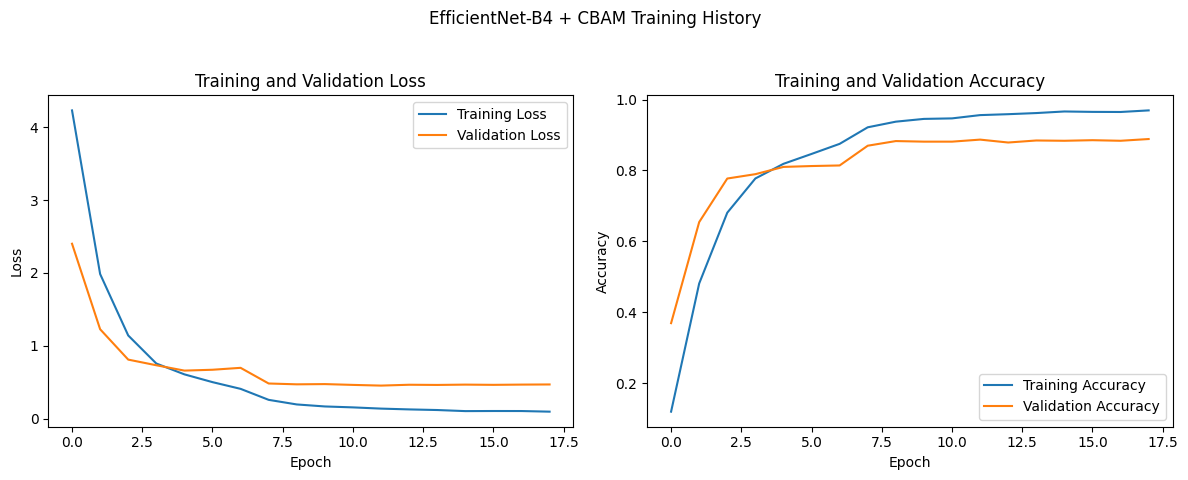

In [ ]:
epochs_range = range(18)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.suptitle("EfficientNet-B4 + CBAM Training History")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Evaluating on Test Set

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    accuracy = running_corrects.double() / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy



In [ ]:
test_accuracy = evaluate_model(model_ft, dataloaders['test'])
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 503/503 [01:59<00:00,  4.22batch/s]

Test Accuracy: 0.8851
Final Test Accuracy: 0.8851


#Calculate Evaluation Metrics

In [ ]:
def calculate_and_display_metrics(model, dataloader, device, class_names, plot_cm=True):
    """
    Calculates and displays detailed classification metrics.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the test set.
        device (torch.device): The device to run evaluation on (CPU or CUDA).
        class_names (list): A list of strings containing the names of the classes.
        plot_cm (bool): Whether to plot the confusion matrix heatmap.
    """
    print("\nCalculating Evaluation Metrics...")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)


    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=None, digits=4, zero_division=0)
    print(report)

    report_dict = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    print(f"Weighted Avg Precision: {report_dict['weighted avg']['precision']:.4f}")
    print(f"Weighted Avg Recall:    {report_dict['weighted avg']['recall']:.4f}")
    print(f"Weighted Avg F1-Score:  {report_dict['weighted avg']['f1-score']:.4f}")
    print(f"Macro Avg Precision:    {report_dict['macro avg']['precision']:.4f}")
    print(f"Macro Avg Recall:       {report_dict['macro avg']['recall']:.4f}")
    print(f"Macro Avg F1-Score:     {report_dict['macro avg']['f1-score']:.4f}")


    # Confusion Matrix
    print("\nGenerating Confusion Matrix...")
    cm = confusion_matrix(all_labels, all_preds)

    if plot_cm:
        if len(class_names) > 50:
             print("Plotting Confusion Matrix (labels omitted due to large number of classes)...")
             plt.figure(figsize=(20, 20)) # Make it large
             sns.heatmap(cm, annot=False, fmt='d', cmap='Blues') # No annotations, they'd overlap
             plt.ylabel('Actual Label')
             plt.xlabel('Predicted Label')
             plt.title('Confusion Matrix (196x196)')
             plt.tight_layout()
             plt.show()
    else:
        print("Confusion Matrix calculation complete (plotting disabled).")

    return accuracy, report, cm


Calculating Evaluation Metrics...


Evaluating: 100%|██████████| 503/503 [02:06<00:00,  3.99batch/s]



Overall Test Accuracy: 0.8851

Classification Report:
              precision    recall  f1-score   support

           0     0.8333    0.9091    0.8696        44
           1     0.9535    0.9318    0.9425        44
           2     0.6818    0.9375    0.7895        32
           3     0.8200    0.9535    0.8817        43
           4     0.9767    1.0000    0.9882        42
           5     1.0000    0.7500    0.8571        40
           6     0.8974    0.8974    0.8974        39
           7     0.7500    0.7333    0.7416        45
           8     0.7568    0.6829    0.7179        41
           9     0.8929    0.7576    0.8197        33
          10     0.8537    0.9211    0.8861        38
          11     0.5714    0.7000    0.6292        40
          12     0.5750    0.5476    0.5610        42
          13     0.7447    0.8537    0.7955        41
          14     0.8333    0.9302    0.8791        43
          15     0.9355    0.8056    0.8657        36
          16     0.8269   

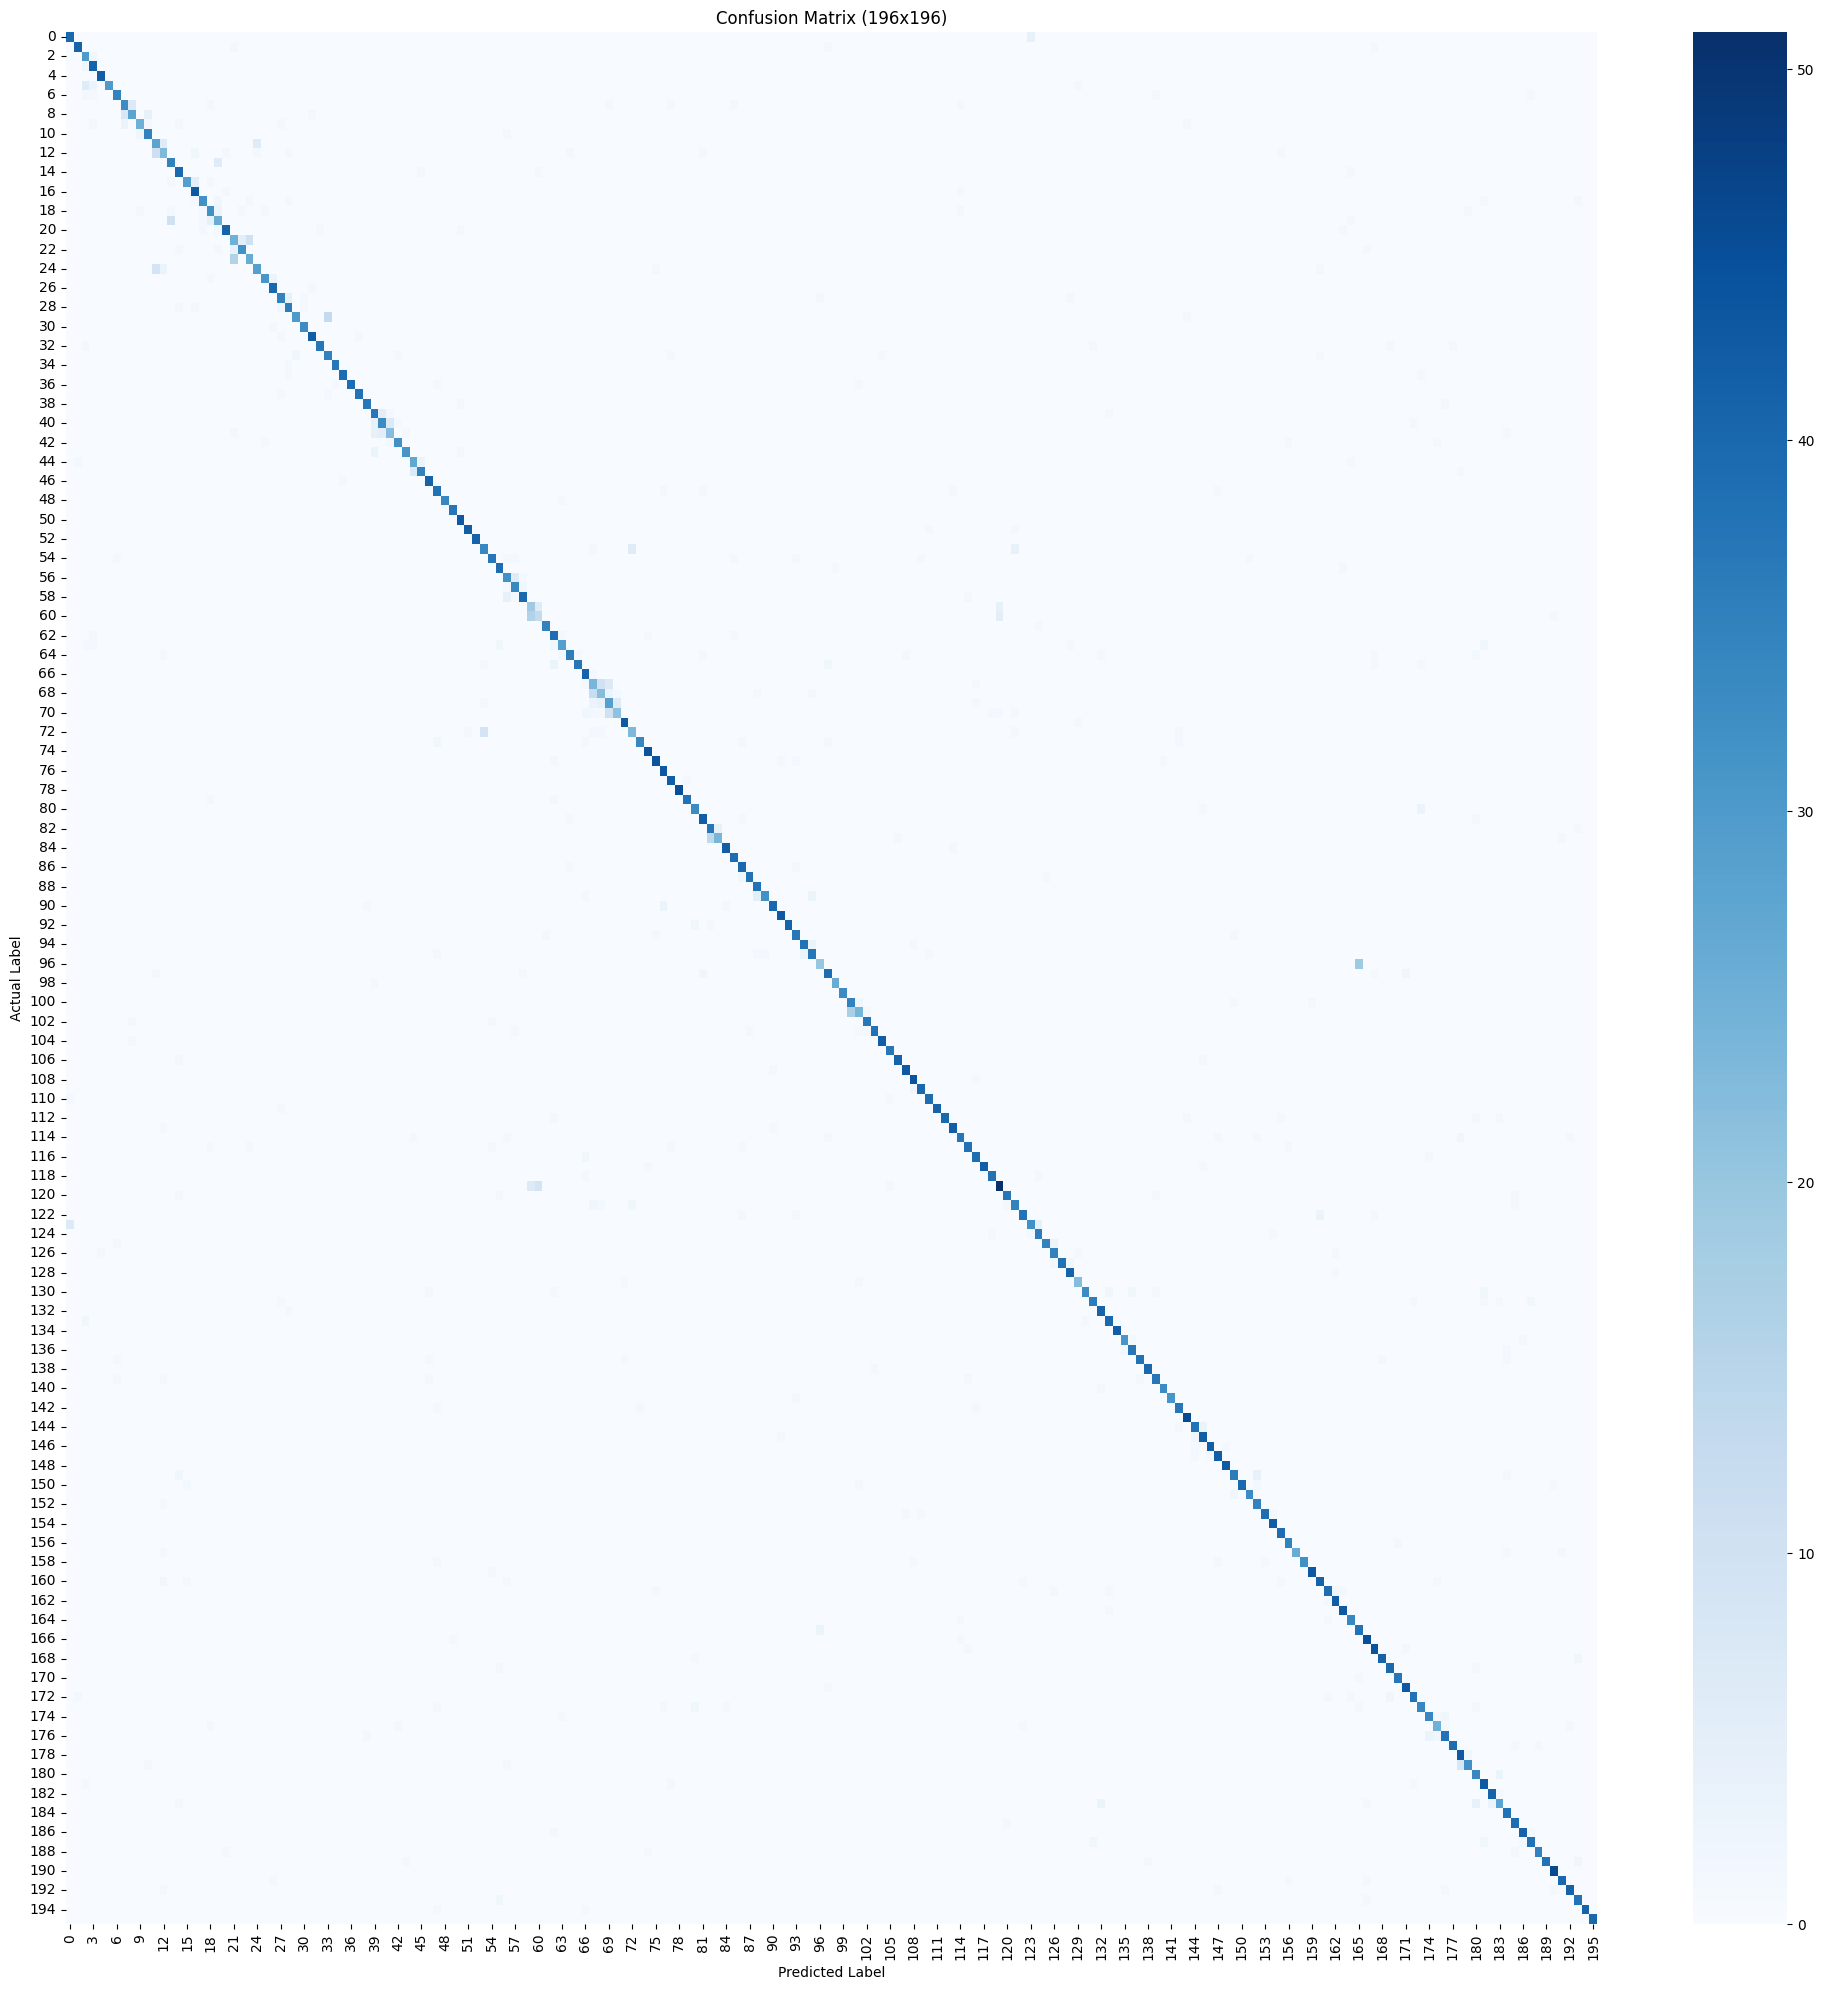


--- Evaluation Finished ---


In [ ]:

if 'class_names' not in globals():
     try:
        class_names = test_dataset.classes
        print("Reloaded class names.")
     except:
        print("Warning: Could not retrieve class names. Confusion matrix labels will be numeric.")
        class_names = []

calculate_and_display_metrics(model=model_ft,
                              dataloader=dataloaders['test'],
                              device=device,
                              class_names=class_names,
                              plot_cm=True)


print("\n--- Evaluation Finished ---")

#Retrieving the class activation map

showing spatial importance of features on our model outputs

In [ ]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
%matplotlib inline
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp, LayerCAM, SSCAM
from torchcam.utils import overlay_mask
import random

In [ ]:
target_layer_for_cam = model_ft.cbam
cam_extractor = SmoothGradCAMpp(model_ft, target_layer=target_layer_for_cam)

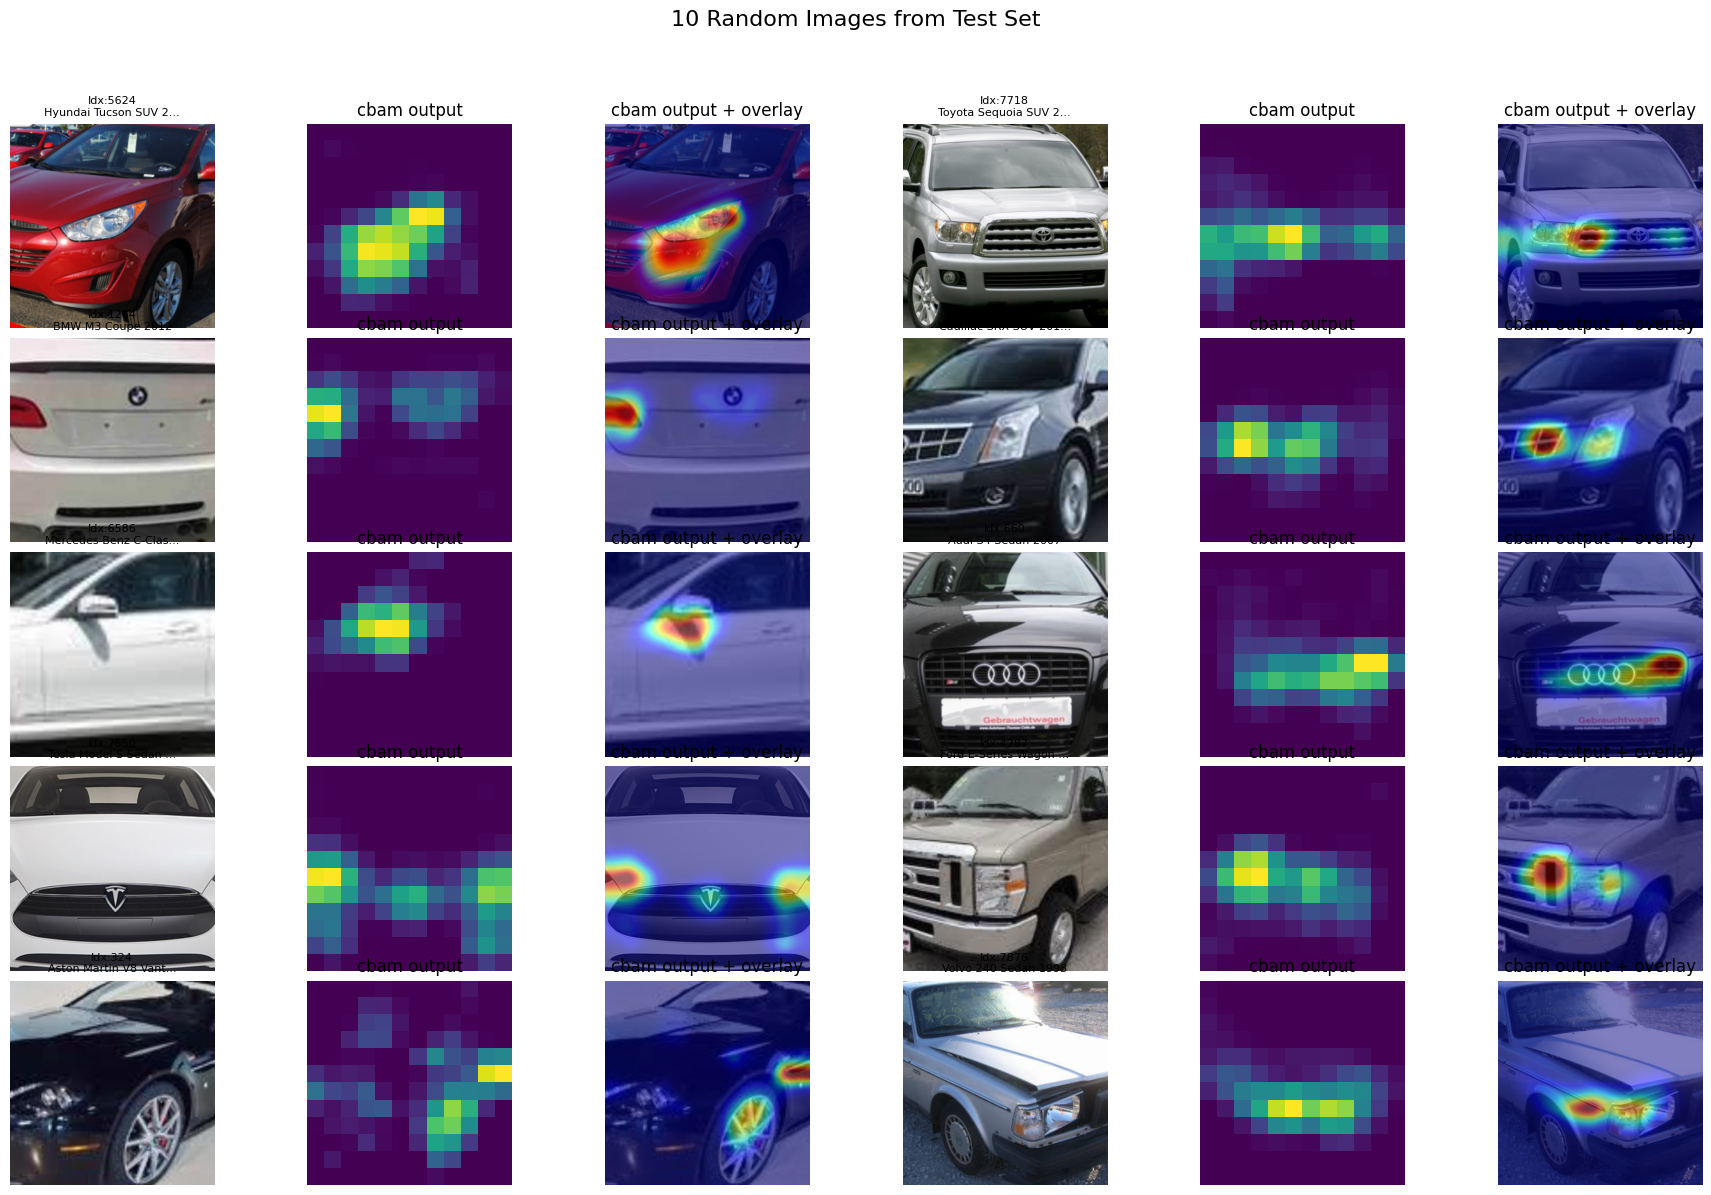

In [ ]:
# Determine grid layout
num_images = 10
grid_cols = 6
grid_rows = ((num_images * 3)+ grid_cols - 1) // grid_cols

plt.figure(figsize=(grid_cols * 3, grid_rows * 3.5))

for i in range(num_images):

    random_idx = random.randint(0, len(test_dataset) - 1)


    image_tensor, label_idx = test_dataset[random_idx]


    img_to_display = image_tensor.clone().cpu()
    for channel_idx in range(img_to_display.shape[0]):
        img_to_display[channel_idx] = img_to_display[channel_idx] * imagenet_std[channel_idx] + imagenet_mean[channel_idx]

    img_to_display = img_to_display.permute(1, 2, 0) # C, H, W -> H, W, C
    img_to_display = torch.clamp(img_to_display, 0, 1) # Clip to [0, 1]
    img_to_display_numpy = img_to_display.numpy()


    plt.subplot(grid_rows, grid_cols, 1 + (i * 3))
    plt.imshow(img_to_display_numpy)

    title_str = f"Idx:{random_idx}\nLbl:{label_idx}"
    if hasattr(test_dataset, 'classes') and test_dataset.classes:
        try:
            class_name = test_dataset.classes[label_idx]
            # Shorten long class names for title
            max_len = 20
            class_name_short = (class_name[:max_len] + '...') if len(class_name) > max_len else class_name
            title_str = f"Idx:{random_idx}\n{class_name_short}"
        except IndexError:
            pass
    plt.title(title_str, fontsize=8)
    plt.axis('off')


    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_(True)
    out = model_ft(image_tensor)
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)

    plt.subplot(grid_rows, grid_cols, 2 + (i * 3))

    for name, cam in zip(cam_extractor.target_names, cams):
      plt.imshow(cam.squeeze(0).cpu().numpy())
      plt.axis('off')
      plt.title(name + " output")


    plt.subplot(grid_rows, grid_cols, 3 + (i * 3))
    # Overlayed on the image
    for name, cam in zip(cam_extractor.target_names, cams):
      result = overlay_mask(to_pil_image(img_to_display_numpy), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
      plt.imshow(result)
      plt.axis('off')
      plt.title(name+" output + overlay")

plt.suptitle(f"{num_images} Random Images from Test Set", fontsize=16)
plt.tight_layout(rect=[0, 0.3, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

#Inference phase

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 859.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

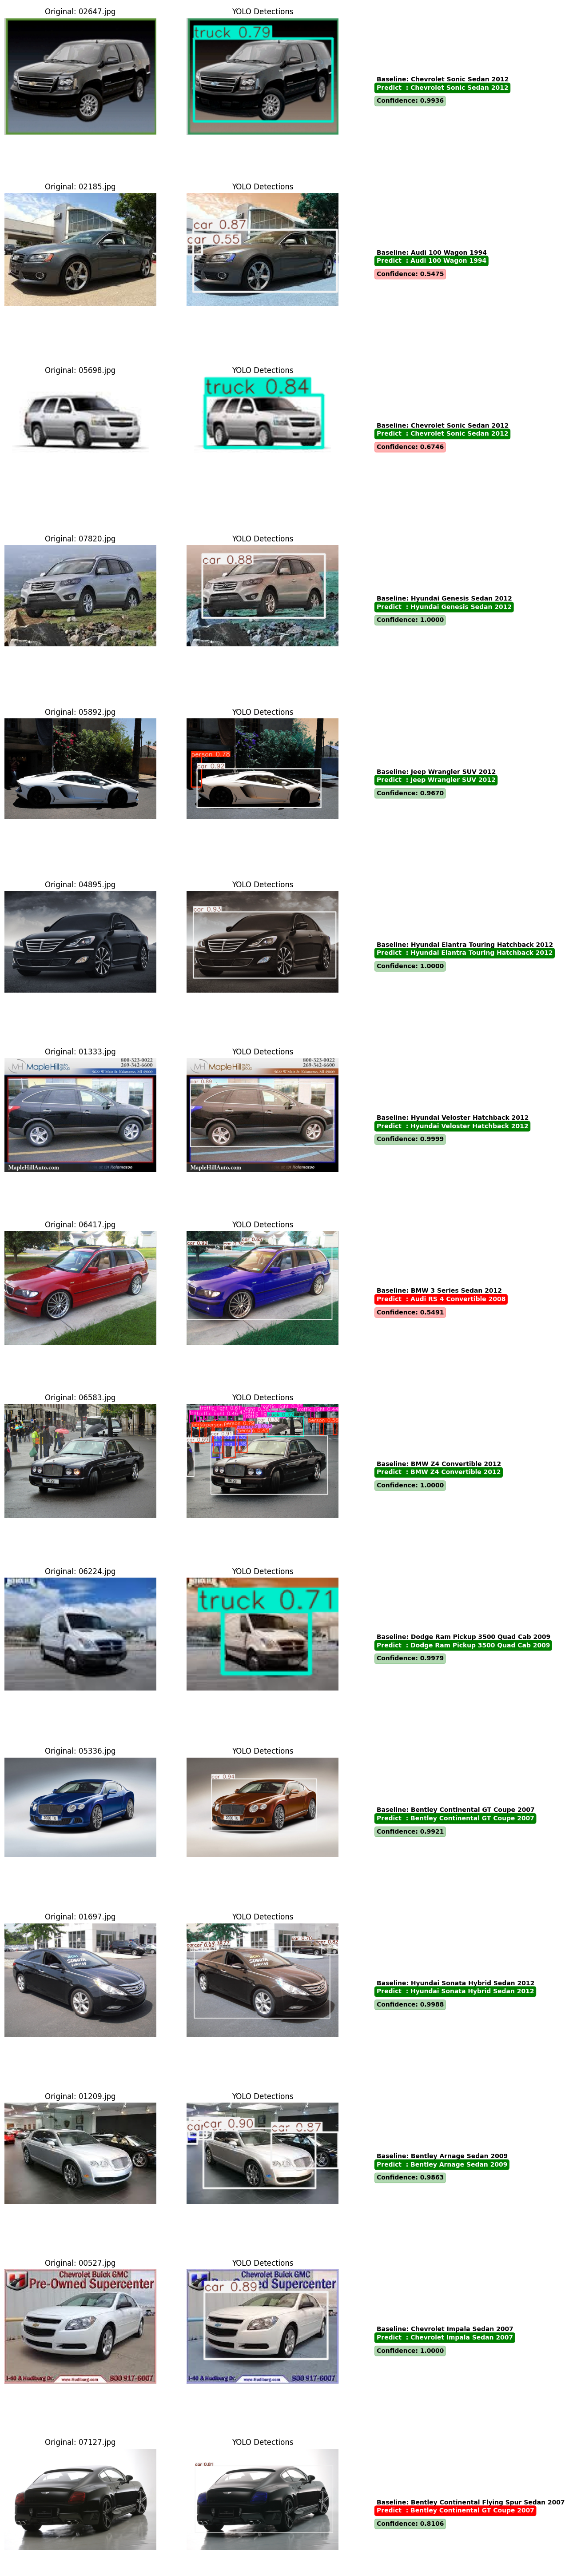

In [ ]:
from ultralytics import YOLO
from random import randint

num_images_to_process = 15
grid_cols_per_image = 3
grid_rows_total = num_images_to_process
plt.figure(figsize=(grid_cols_per_image * 5, grid_rows_total * 5))
# plt.suptitle(f"YOLO + FGVC Inference Pipeline", fontsize=16)

yolo_model = YOLO('yolo12n.pt')

transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE + 32),
            transforms.CenterCrop(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_mean, imagenet_std)
            ])

test_image_paths_dataset = datasets.ImageFolder(test_dir)

model_ft.eval() 

for i in range(num_images_to_process):
    
    random_idx = randint(0, len(test_image_paths_dataset) - 1)
    image_path, car_idx = test_image_paths_dataset.samples[random_idx] 
    original_pil_image = Image.open(image_path)

    
    current_plot_idx = 1 + (i * 3)
    plt.subplot(grid_rows_total, grid_cols_per_image, current_plot_idx)

    plt.imshow(original_pil_image)
    plt.title(f"Original: {os.path.basename(image_path)}")
    plt.axis('off')

    
    yolo_results = yolo_model(original_pil_image, verbose=False) # verbose=False for less output

    
    current_plot_idx += 1
    plt.subplot(grid_rows_total, grid_cols_per_image, current_plot_idx)

    if yolo_results and len(yolo_results[0].boxes) > 0:
        annotated_yolo_frame = yolo_results[0].plot() # Returns RGB NumPy array
        plt.imshow(Image.fromarray(annotated_yolo_frame))
        plt.title("YOLO Detections")
    else:
        plt.imshow(original_pil_image)
        plt.title("YOLO - No Detections")
    plt.axis('off')


    current_plot_idx += 1
    plt.subplot(grid_rows_total, grid_cols_per_image, current_plot_idx)
    fgvc_performed = False

    if yolo_results and len(yolo_results[0].boxes) > 0:
        best_car_crop = None
        best_car_conf = 0.0

        for box in yolo_results[0].boxes:
            class_id = int(box.cls[0])
            class_name_yolo = yolo_model.names[class_id]
            confidence_yolo = float(box.conf[0])

            if class_name_yolo.lower() in ['car', 'truck', 'bus'] and confidence_yolo > 0.3: # Filter for cars with decent confidence
                xyxy = box.xyxy[0].cpu().numpy().astype(int) # [x1, y1, x2, y2]

                
                cropped_car_pil = original_pil_image.crop((xyxy[0], xyxy[1], xyxy[2], xyxy[3]))

                if confidence_yolo > best_car_conf :
                    best_car_conf = confidence_yolo
                    best_car_crop = cropped_car_pil

        if best_car_crop:
            car_tensor_fgvc = transform(best_car_crop).unsqueeze(0).to(device)
            with torch.no_grad():
                outputs_fgvc = model_ft(car_tensor_fgvc)
                
            probabilities_fgvc = torch.softmax(outputs_fgvc, dim=1)[0]
            confidence_fgvc, predicted_idx_fgvc = torch.max(probabilities_fgvc, 0)
            

            pred_class_name_fgvc = test_image_paths_dataset.classes[predicted_idx_fgvc.item() - 1] \
                if test_image_paths_dataset.classes and 0 <= predicted_idx_fgvc.item() < len(test_image_paths_dataset.classes) \
                else f"Idx: {predicted_idx_fgvc.item() - 1}"

            ax = plt.gca()
            ax.text(0.05, 0.5, f"Baseline: {test_image_paths_dataset.classes[car_idx - 1]}", horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color="black", weight='bold')
            ax.text(0.05, 0.4, f'Predict  : {pred_class_name_fgvc}', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes, color="white", weight='bold', bbox=dict(boxstyle="round",
                   ec = "green" if (car_idx - 1 == predicted_idx_fgvc.item() - 1) else "red",
                   fc = "green" if (car_idx - 1 == predicted_idx_fgvc.item() - 1) else "red"
                   ))
            ax.text(0.05, 0.33, f"Confidence: {confidence_fgvc.item():.4f}", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, color="black", weight='bold', bbox=dict(boxstyle="round",
                   ec = ('green', 0.3) if confidence_fgvc.item() > 0.7 else ('red', 0.3),
                   fc = ('green', 0.3) if confidence_fgvc.item() > 0.7 else ('red', 0.3)
                   ))
            # print(f"  FGVC Result: {pred_class_name_fgvc}, Confidence: {confidence_fgvc.item():.4f} (on YOLO crop)")
            fgvc_performed = True

    if not fgvc_performed:
        ax = plt.gca()
        ax.text(0.5, 0.5, 'No Car for FGVC', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.axis('off')


# plt.tight_layout()
plt.show()